### Prepare landcover input for discretization ###
Prepare landcover input data for the domain area. This step includes:<br>
1. project large-domain input into a common projection system.
2. extract input for the domain area.
3. resample input according to a reference raster (if needed).
4. classifiy landcover into canopy and non-canopy.
5. check domain landcover and landcover class.

In [1]:
# import libraries
import os, sys 
sys.path.append('../')
import functions.geospatial_analysis as ga
import functions.geospatial_plot as gp
import functions.utils as ut
import rasterio as rio
import rasterio.shutil
from rasterio.warp import Resampling

#### Set data files, paths and other entries ####

In [2]:
# common paths
control_file    = '/Users/drc858/GitHub/watershed_tools/test_cases/tuolumne/control_tuolumne.txt'
basin_data_path   = ut.read_from_control(control_file, 'basin_data_path')
basin_name        = ut.read_from_control(control_file, 'basin_name')
plot_path         = os.path.join(basin_data_path, 'plots')  # this is made in 'prepare_basin_shapefiles' script

In [3]:
# define equal area projection system
new_epsg = ut.read_from_control(control_file, 'epsg') 
dest_crs = rio.crs.CRS.from_epsg(new_epsg)

In [4]:
# large-domain data
landcover_raster                = ut.read_from_control(control_file, 'fulldom_landcover_raster')

# basin data
basin_gru_shp                   = ut.set_filename(control_file, 'basin_gru_shp')
basin_flowlines_shp             = ut.set_filename(control_file, 'basin_flowlines_shp')
basin_landcover_raster          = ut.set_filename(control_file, 'basin_landcover_raster') 
basin_landcover_resample_raster = ut.set_filename(control_file, 'basin_landcover_resample_raster')
basin_canopy_class_raster       = ut.set_filename(control_file, 'basin_canopy_class_raster')
refraster                       = ut.set_filename(control_file, 'refraster')

# derived filenames
landcover_prj_raster   = landcover_raster.split('.tif')[0]+'_prj.tif'   # note, this full-dom file exists or must written somewhere writable
basin_gru_prj_shp      = basin_gru_shp.split('.shp')[0]+'_prj.shp' 
basin_boundary_prj_shp = basin_gru_prj_shp.split('.shp')[0]+'_boundary.shp'
basin_landcover_resample_crop_raster = basin_landcover_resample_raster.split('.tif')[0]+'_crop.tif'

#### 2. Extract domain landcover ####

In [5]:
if not os.path.exists(basin_landcover_raster):
    # if needed, reproject original landcover to target equal-area coordinates
    if not os.path.exists(landcover_prj_raster):
        ga.reproject_raster(landcover_raster, landcover_prj_raster, dest_crs, Resampling.nearest) 
        print('reprojected landcover raster:', landcover_prj_raster) 

    # clip raster based on projected basin extent
    if not os.path.exists(basin_landcover_raster):
        ga.crop_raster(landcover_prj_raster, basin_gru_prj_shp, basin_landcover_raster)
    
print('cropped reprojected landcover raster:', basin_landcover_raster)

reprojected landcover raster: /Users/drc858/Data/GISData/landCover/annual_climate_lc_prj_prj.tif
cropped reprojected landcover raster: /Users/drc858/GitHub/watershed_tools/test_cases/tuolumne/gis/landcover.tif


#### Resample domain landcover and classify into canopy vs non-canopy ####
Resample is only applied to the domain raster that has a coarser resolution than the reference raster. The reference raster is specified by user (by default, it refers to the domain DEM).<br>

Data source: 20-category IGBP land cover dataset at 1/160 degree resolution (IGBP, 1990)<br>
Canopy class includes: 1 Evergreen needleleaf forests, 2 Evergreen broadleaf forests, 3 Deciduous needleleaf forests, 4 Deciduous broadleaf forests, 5 Mixed forests, 6 Closed shrublands, 8 Woody savannas. 

In [6]:
# resample raster to refraster specs (if needed)
if not os.path.exists(basin_landcover_resample_raster):
    ga.resample_raster(basin_landcover_raster, refraster, basin_landcover_resample_raster) 
print('resampled landcover: ', basin_landcover_resample_raster)

# apply canopy decision
if not os.path.exists(basin_canopy_class_raster):
    ga.classify_landcover(basin_landcover_resample_raster, basin_canopy_class_raster)
print('classified canopy/no-canopy landcover: ', basin_canopy_class_raster)

resampled landcover:  /Users/drc858/GitHub/watershed_tools/test_cases/tuolumne/gis/lc_resample.tif
classified canopy/no-canopy landcover:  /Users/drc858/GitHub/watershed_tools/test_cases/tuolumne/gis/canopy_class.tif


#### Visualize basin landcover classification ####

data_unique: [ 0  1  3  5  6  7  8  9 10 12 14 16]
data_counts: [   637  14347    443    232     49   2787  18453    210 135828   1377
    303    400]
length data_unique: 12
legend_labels: {0: ['black', 'Unspecified'], 1: ['darkgreen', 'Evergreen needleleaf forests'], 3: ['forestgreen', 'Deciduous needleleaf forests'], 5: ['lightgreen', 'Mixed forests'], 6: ['olivedrab', 'Closed shrublands'], 7: ['darkseagreen', 'Open shrublands'], 8: ['goldenrod', 'Woody savannas'], 9: ['gold', 'Savannas'], 10: ['mediumaquamarine', 'Grasslands'], 12: ['darkorange', 'Croplands'], 14: ['bisque', 'Cropland/natural vegetation mosaics'], 16: ['grey', 'Barren']}


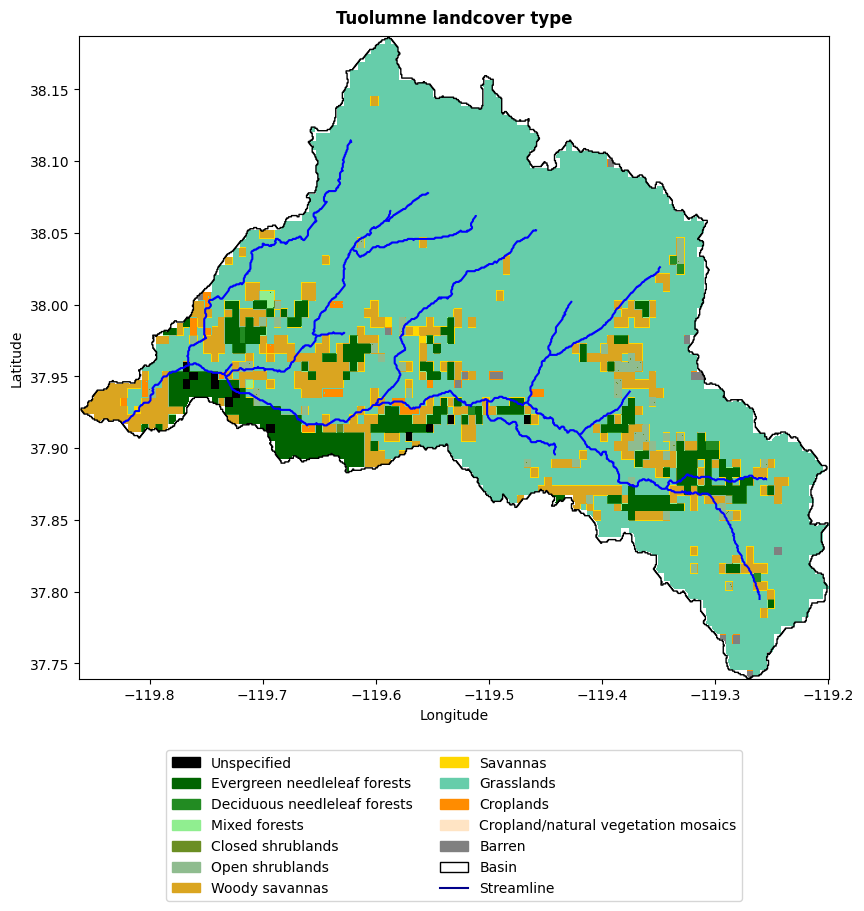

In [7]:
# plot settings
wgs_epsg  = 4326
figsize   = (15, 15*0.6) # width, height in inches
title     = basin_name.capitalize() + ' landcover type'
leg_ncol  = 2
leg_loc   = 'upper center'
leg_bbox_to_anchor = (0.5,-0.1)
  
# IGBP classifications
legend_dict={0:["black", "Unspecified"],
             1:["darkgreen", "Evergreen needleleaf forests"],
             2:["green", "Evergreen broadleaf forests"],
             3:["forestgreen", 'Deciduous needleleaf forests'],
             4:["limegreen", 'Deciduous broadleaf forests'], 
             5:["lightgreen", 'Mixed forests'], 
             6:["olivedrab", 'Closed shrublands'], 
             7:["darkseagreen", 'Open shrublands'], 
             8:["goldenrod", 'Woody savannas'], 
             9:["gold", 'Savannas'], 
             10:["mediumaquamarine", 'Grasslands'], 
             11:["powderblue", 'Permanent wetlands'], 
             12:["darkorange", 'Croplands'], 
             13:["lightcoral", 'Urban and built-up lands'], 
             14:["bisque", 'Cropland/natural vegetation mosaics'], 
             15:["snow", 'Snow and ice'], 
             16:["grey", 'Barren'], 
             17:["royalblue", 'Water bodies']} 

# set plot name and color choice
output_fig_file = os.path.join(plot_path, 'landcover_and_bound_stream.png')   
cmap_str='user'

# plot land cover classes
# (something is wrong with the categories shown in the plot but the categories appear to be ok from the data)
gp.plot_raster_and_bound_stream(basin_landcover_resample_raster, basin_gru_prj_shp, basin_flowlines_shp, wgs_epsg, cmap_str,
                                legend_dict, figsize,title, leg_loc, leg_bbox_to_anchor, leg_ncol, output_fig_file)

#### Visualize basin landcover canopy/no-canopy classification ####

data_unique: [1 2]
data_counts: [ 17858 157208]
length data_unique: 2
legend_labels: {1: ['black', 'Canopy'], 2: ['whitesmoke', 'Non-canopy']}


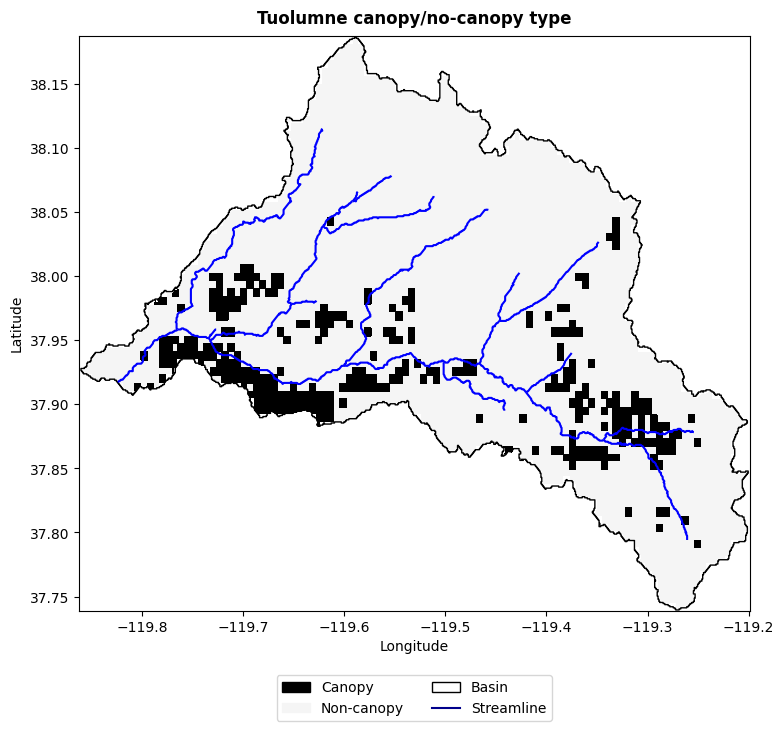

In [8]:
# plot settings
wgs_epsg    = 4326
figsize     = (12, 12*0.6) # width, height in inches
title       = basin_name.capitalize() + ' canopy/no-canopy type'
leg_ncol    = 2
leg_loc     = 'upper center'
leg_bbox_to_anchor = (0.5,-0.1)
legend_dict = {1:["black", "Canopy"],
               2:["whitesmoke", "Non-canopy"]} 

# set plot name and color choice
output_fig_file = os.path.join(plot_path, 'canopy_class_and_bound_stream.png')   
cmap_str = 'user'

# plot canopy vs no-canopy decision
gp.plot_raster_and_bound_stream(basin_canopy_class_raster, basin_gru_prj_shp, basin_flowlines_shp,
                                wgs_epsg, cmap_str, legend_dict, figsize, title, leg_loc, leg_bbox_to_anchor, leg_ncol, output_fig_file)

In [9]:
# the above plot may crashes the Jupyterhub kernel / drops core ... but after it makes the plot successfully